In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
import os

# Get token
with open('token') as f:
    token = f.read()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = token

In [13]:
topics = pd.read_csv('data/topics.csv')
content = pd.read_csv('data/content.csv')

## Topics

In [14]:
topics.sample(5)

,id,title,description,channel,category,level,language,parent,has_content
35570,t_76c12b3bf8e5,Построяване на графиките на синусоидални функции,Научи как да чертаеш графиката на синусоидални...,000cf7,source,4,bg,t_57335e6dddbb,True
41858,t_8bd6243e50d0,Law of chemical equilibrium & equilibrium cons...,NaN,2ee29d,aligned,4,en,t_59acc99f6a14,True
63660,t_d4ab3e41dded,A2 Nombres relatifs,NaN,bfc678,supplemental,3,fr,t_d6c8a0a9feae,False
20430,t_44d0620c4de0,Ions and Ionic Compounds,NaN,344113,supplemental,4,en,t_10caf4322e6a,True
21368,t_47ff0966e8f6,Intro to inverse functions,NaN,2ee29d,aligned,4,en,t_2f5e72034e8d,True


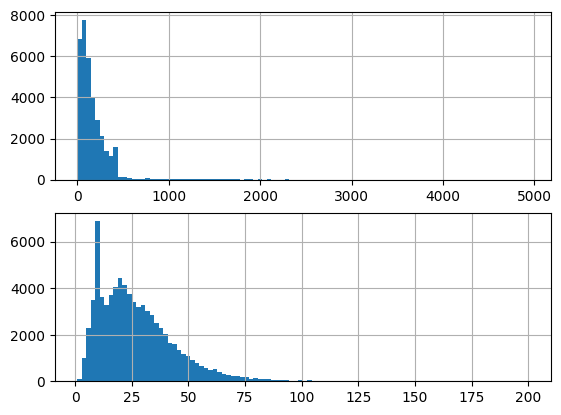

In [15]:
plt.subplot(2, 1, 1)
topics['description'][topics['description'].notna()].str.len().hist(bins=100)
plt.subplot(2, 1, 2)
topics['title'][topics['title'].notna()].str.len().hist(bins=100)
plt.show()

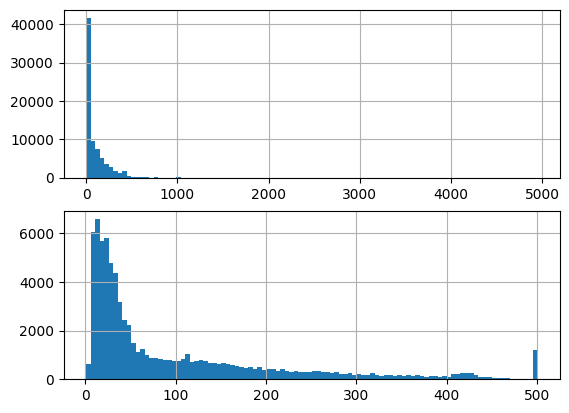

0    Откриването на резисторите Изследване на матер...
1              Unit 3.3 Enlargements and Similarities 
2    Entradas e saídas de uma função Entenda um pou...
3                                         Transcripts 
4    Графики на експоненциални функции (Алгебра 2 н...
Name: content, dtype: object

In [16]:
topics['title'] = topics['title'].fillna('')
topics['description'] = topics['description'].fillna('')
topics['content'] = topics['title'] + ' ' + topics['description']
plt.subplot(2, 1, 1)
topics['content'].str.len().hist(bins=100)

plt.subplot(2, 1, 2)
topics.loc[:, 'content'] = topics['content'].map(lambda x: x[:500])
topics['content'].str.len().hist(bins=100)
plt.show()

topics['content'].head()

In [17]:
from tqdm.notebook import tqdm
from langchain_core.documents import Document

documents = []
for i, t in tqdm(topics.iterrows(), total = len(topics)):
    metadata = {
        'level': t['level'],
        'parent': t['parent'],
        'id': t['id'],
        'has_content': t['has_content'],
        'channel': t['channel'],
        'language': t['language'],
    }
    doc = Document(t['content'], metadata=metadata)
    documents.append(doc)

  0%|          | 0/76972 [00:00<?, ?it/s]

In [18]:
from langchain_huggingface import HuggingFaceEndpointEmbeddings

embeddings = HuggingFaceEndpointEmbeddings(
   model="Qwen/Qwen3-Embedding-8B",
   task="feature-extraction",
)

In [19]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="topics",
    embedding_function=embeddings,
    persist_directory="data/vector_store",
)

In [20]:
batch_size = 100
for i in tqdm(range(0, len(documents), batch_size)):
    vector_store.add_documents(documents[i:i+batch_size])

  0%|          | 0/770 [00:00<?, ?it/s]

In [21]:
retriever = vector_store.as_retriever()

In [22]:
retriever.invoke('Resistors')

[Document(id='a419a411-7ec4-49f3-8004-d4fa2e4dee6e', metadata={'level': 4, 'channel': 'fef095', 'id': 't_bd904a5949a5', 'has_content': True, 'parent': 't_2a485eeebef7'}, page_content='Resistor Circuits '),
 Document(id='543dd4ed-a18b-438c-9c16-bae18f9dd1ee', metadata={'parent': 't_326445511afc', 'id': 't_60622f4a2f4a', 'channel': '344113', 'has_content': True, 'level': 3}, page_content='Resistor circuits '),
 Document(id='87b52dd2-22f2-4fad-9767-b168a1555df3', metadata={'parent': 't_8fb9fc6396c4', 'channel': '344113', 'has_content': True, 'level': 5, 'id': 't_0431d2e6418a'}, page_content='Resistors in Series '),
 Document(id='efd7a27e-1a2e-4d24-9791-5629e22ecf53', metadata={'id': 't_8fab1f793a8a', 'has_content': True, 'level': 4, 'channel': 'fef095', 'parent': 't_2a485eeebef7'}, page_content='Resistors in Series ')]